In [32]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
import joblib
import os
from typing import Tuple, Dict
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# ==============================================================================
# 1. DATA PROCESSOR CLASS
# ==============================================================================
class DataProcessor:
    def __init__(self, data_path: str, save_path: str):
        self.data_path = data_path
        self.save_path = save_path
        self.scaler = MinMaxScaler()

    def load_and_preprocess(self) -> Tuple[torch.Tensor, torch.Tensor, Dict]:
        df = pd.read_csv(self.data_path)
        print(f"📊 Original data shape: {df.shape}")
        df = df.drop(['UDI', 'Product ID', 'Target'], axis=1)

        numerical_cols = ['Air temperature [K]', 'Process temperature [K]',
                         'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
        X_numerical = self.scaler.fit_transform(df[numerical_cols])

        joblib.dump(self.scaler, f'{self.save_path}/scaler.pkl')
        print(f"✅ Scaler saved to {self.save_path}/scaler.pkl")

        type_dummies = pd.get_dummies(df['Type'], prefix='Type')
        X_type = type_dummies.values

        unique_failures = df['Failure Type'].unique()
        failure_to_idx = {}
        if 'No Failure' in unique_failures:
            failure_to_idx['No Failure'] = 0
            idx = 1
            for failure in unique_failures:
                if failure != 'No Failure':
                    failure_to_idx[failure] = idx
                    idx += 1
        else:
            failure_to_idx = {failure: idx for idx, failure in enumerate(unique_failures)}

        y = df['Failure Type'].map(failure_to_idx).values

        X = np.concatenate([X_numerical, X_type], axis=1)
        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.LongTensor(y)

        metadata = {
            'num_features': X.shape[1],
            'num_classes': len(unique_failures),
        }
        return X_tensor, y_tensor, metadata

    def apply_smote_balancing(self, X_train: torch.Tensor, y_train: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        print("\n⚖️ Applying SMOTE balancing...")
        X_train_np, y_train_np = X_train.numpy(), y_train.numpy()
        train_counts = Counter(y_train_np)

        sampling_strategy = {k: 2500 for k in train_counts if k != 0}
        sampling_strategy[0] = train_counts[0]

        smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42, k_neighbors=3)
        X_balanced, y_balanced = smote.fit_resample(X_train_np, y_train_np)

        print("\n📊 After SMOTE:")
        for class_idx, count in Counter(y_balanced).items(): print(f"  Class {class_idx}: {count}")

        return torch.FloatTensor(X_balanced), torch.LongTensor(y_balanced)

# ==============================================================================
# 2. PYTORCH DATASET AND MODEL CLASSES
# ==============================================================================
class TabularDataset(Dataset):
    def __init__(self, X, y): self.X = X.clone().detach().float(); self.y = y.clone().detach().long()
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

class AdvancedDNN(nn.Module):
    def __init__(self, input_dim: int, num_classes: int, dropout_rate: float = 0.3):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.block1 = self._make_block(512, 256, dropout_rate)
        self.block2 = self._make_block(256, 128, dropout_rate)
        self.block3 = self._make_block(128, 64, dropout_rate)
        self.classifier = nn.Sequential(nn.Linear(64, 32), nn.ReLU(), nn.Dropout(dropout_rate), nn.Linear(32, num_classes))
    def _make_block(self, i, o, d): return nn.Sequential(nn.Linear(i, o), nn.BatchNorm1d(o), nn.ReLU(), nn.Dropout(d))
    def forward(self, x):
        x = torch.relu(self.bn1(self.input_layer(x))); x = self.block1(x); x = self.block2(x); x = self.block3(x)
        return self.classifier(x)

class TabularLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, **kwargs):
        super().__init__()
        self.feature_embedding = nn.Linear(1, 16)
        self.lstm = nn.LSTM(16, 128, 2, batch_first=True, dropout=0.3, bidirectional=True)
        self.attention = nn.MultiheadAttention(128 * 2, num_heads=8, dropout=0.3, batch_first=True)
        self.classifier = nn.Sequential(nn.Linear(128 * 2 * input_dim, 256), nn.ReLU(), nn.Dropout(0.3), nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.3), nn.Linear(128, num_classes))
    def forward(self, x):
        b, s = x.shape; x = self.feature_embedding(x.unsqueeze(-1)); o, _ = self.lstm(x); a, _ = self.attention(o, o, o); return self.classifier(a.reshape(b, -1))

class TabularTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, **kwargs):
        super().__init__()
        d_model = 128
        self.feature_projection = nn.Linear(1, d_model)
        self.pos_encoding = self._create_positional_encoding(input_dim, d_model)
        e = nn.TransformerEncoderLayer(d_model=d_model, nhead=8, dim_feedforward=d_model*4, dropout=0.3, activation='gelu', batch_first=True)
        self.transformer = nn.TransformerEncoder(e, num_layers=4)
        self.classifier = nn.Sequential(nn.Linear(d_model, 256), nn.GELU(), nn.Dropout(0.3), nn.Linear(256, 128), nn.GELU(), nn.Dropout(0.3), nn.Linear(128, num_classes))
    def _create_positional_encoding(self, m, d):
        p = torch.zeros(m, d); pos = torch.arange(0, m, dtype=torch.float).unsqueeze(1); div = torch.exp(torch.arange(0, d, 2).float() * (-np.log(10000.0) / d)); p[:, 0::2] = torch.sin(pos * div); p[:, 1::2] = torch.cos(pos * div); return p.unsqueeze(0)
    def forward(self, x):
        b, s = x.shape; x = self.feature_projection(x.unsqueeze(-1)); x = x + self.pos_encoding[:, :s, :].to(x.device); x = self.transformer(x); return self.classifier(x.mean(dim=1))

# ==============================================================================
# 3. ADVANCED TRAINER CLASS
# ==============================================================================
class AdvancedTrainer:
    def __init__(self, device: str = None):
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"🔥 Using device: {self.device}")

    def calculate_class_weights(self, y_train, num_classes):
        class_counts = torch.bincount(y_train, minlength=num_classes)
        return len(y_train) / (num_classes * class_counts.float()).to(self.device)

    def train_model(self, model, train_loader, val_loader, optimizer_name, num_classes, y_train, epochs=150) -> Dict:
        model.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=self.calculate_class_weights(y_train, num_classes))
        optimizers = {'adam': optim.AdamW(model.parameters(), lr=0.001), 'rmsprop': optim.RMSprop(model.parameters(), lr=0.001), 'sgd_momentum': optim.SGD(model.parameters(), lr=0.01, momentum=0.9)}
        optimizer = optimizers[optimizer_name]
        scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, epochs=epochs, steps_per_epoch=len(train_loader))

        history = {'train_losses': [], 'val_losses': [], 'best_val_f1': 0}
        patience_counter = 0

        for epoch in range(epochs):
            model.train()
            train_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                optimizer.zero_grad(); outputs = model(X_batch); loss = criterion(outputs, y_batch)
                loss.backward(); torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step(); scheduler.step(); train_loss += loss.item()

            model.eval()
            val_loss, val_preds, val_true = 0, [], []
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                    outputs = model(X_batch); loss = criterion(outputs, y_batch)
                    val_loss += loss.item(); val_preds.extend(outputs.argmax(1).cpu().numpy()); val_true.extend(y_batch.cpu().numpy())

            history['train_losses'].append(train_loss / len(train_loader))
            history['val_losses'].append(val_loss / len(val_loader))
            val_f1 = f1_score(val_true, val_preds, average='weighted')

            if val_f1 > history['best_val_f1']:
                history['best_val_f1'] = val_f1
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= 20:
                    print(f"    Early stopping at epoch {epoch+1}")
                    break
        return history

    def evaluate_model(self, model, test_loader):
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(self.device)
                y_true.extend(y_batch.numpy()); y_pred.extend(model(X_batch).argmax(1).cpu().numpy())
        return accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average='weighted')

# ==============================================================================
# 4. MAIN PIPELINE CLASS
# ==============================================================================
class PyTorchPipelineAdvanced:
    def __init__(self, data_path: str, save_path: str = '/content'):
        self.data_path = data_path
        self.save_path = save_path
        self.results = []
        os.makedirs(save_path, exist_ok=True)

    def run_pipeline(self):
        print("🚀 Starting Advanced PyTorch Deep Learning Pipeline")
        processor = DataProcessor(self.data_path, self.save_path)
        X_tensor, y_tensor, metadata = processor.load_and_preprocess()

        indices = torch.randperm(len(X_tensor))
        train_size = int(0.8 * len(X_tensor))
        train_indices, test_indices = indices[:train_size], indices[train_size:]
        X_train, X_test = X_tensor[train_indices], X_tensor[test_indices]
        y_train, y_test = y_tensor[train_indices], y_tensor[test_indices]

        X_train_balanced, y_train_balanced = processor.apply_smote_balancing(X_train, y_train)

        val_size = int(0.2 * len(X_train_balanced))
        val_indices = torch.randperm(len(X_train_balanced))[:val_size]
        train_indices_final = torch.randperm(len(X_train_balanced))[val_size:]

        X_train_final, y_train_final = X_train_balanced[train_indices_final], y_train_balanced[train_indices_final]
        X_val, y_val = X_train_balanced[val_indices], y_train_balanced[val_indices]

        train_loader = DataLoader(TabularDataset(X_train_final, y_train_final), batch_size=128, shuffle=True)
        val_loader = DataLoader(TabularDataset(X_val, y_val), batch_size=128)
        test_loader = DataLoader(TabularDataset(X_test, y_test), batch_size=128)

        models = {'AdvancedDNN': AdvancedDNN, 'TabularLSTM': TabularLSTM, 'TabularTransformer': TabularTransformer}
        optimizers = ['adam', 'rmsprop', 'sgd_momentum']
        trainer = AdvancedTrainer()

        best_model, best_f1 = None, 0

        # --- THIS IS THE FIX ---
        # Create a dictionary with the correct argument names for the model constructors
        model_params = {
            'input_dim': metadata['num_features'],
            'num_classes': metadata['num_classes']
        }

        for model_name, model_class in models.items():
            for optimizer in optimizers:
                print(f"\n🧠 Training {model_name} with {optimizer}...")
                # Use the new model_params dictionary to initialize the model
                model = model_class(**model_params)

                history = trainer.train_model(model, train_loader, val_loader, optimizer, metadata['num_classes'], y_train_final)
                accuracy, f1 = trainer.evaluate_model(model, test_loader)

                if f1 > best_f1:
                    best_f1 = f1
                    best_model = model
                    print(f"    -> New best model found! F1-Score: {f1:.4f}")
                    # Save the history dictionary of the best performing model
                    joblib.dump(history, f'{self.save_path}/best_model_history.pkl')
                    print(f"    -> History saved to {self.save_path}/best_model_history.pkl")

                self.results.append({'Model': model_name, 'Optimizer': optimizer, 'Accuracy': accuracy, 'F1_Score': f1, 'Best_Val_F1': history['best_val_f1']})
                print(f"    ✅ {model_name}-{optimizer}: Test Acc={accuracy:.4f}, Test F1={f1:.4f}")

        if best_model:
            joblib.dump(best_model, f'{self.save_path}/best_deep_learning_model.pkl')
            print(f"\n✅ Best overall model saved to {self.save_path}/best_deep_learning_model.pkl")

        self.save_results()

    def save_results(self):
        results_df = pd.DataFrame(self.results)
        results_df.to_csv(f'{self.save_path}/pytorch_advanced_results.csv', index=False)
        print("\n📊 ADVANCED RESULTS SUMMARY:")
        print("="*80); print(results_df.sort_values('F1_Score', ascending=False).to_string(index=False)); print("="*80)

# ==============================================================================
# 5. EXECUTION BLOCK
# ==============================================================================
if __name__ == "__main__":
    pipeline = PyTorchPipelineAdvanced(data_path='/content/preprocessed_df.csv', save_path='/content')
    pipeline.run_pipeline()

🚀 Starting Advanced PyTorch Deep Learning Pipeline
📊 Original data shape: (10000, 10)
✅ Scaler saved to /content/scaler.pkl

⚖️ Applying SMOTE balancing...

📊 After SMOTE:
  Class 0: 7736
  Class 1: 2500
  Class 2: 2500
  Class 5: 2500
  Class 3: 2500
  Class 4: 2500
🔥 Using device: cuda

🧠 Training AdvancedDNN with adam...
    -> New best model found! F1-Score: 0.9676
    -> History saved to /content/best_model_history.pkl
    ✅ AdvancedDNN-adam: Test Acc=0.9605, Test F1=0.9676

🧠 Training AdvancedDNN with rmsprop...
    Early stopping at epoch 47
    ✅ AdvancedDNN-rmsprop: Test Acc=0.7980, Test F1=0.8699

🧠 Training AdvancedDNN with sgd_momentum...
    ✅ AdvancedDNN-sgd_momentum: Test Acc=0.9390, Test F1=0.9548

🧠 Training TabularLSTM with adam...
    ✅ TabularLSTM-adam: Test Acc=0.9505, Test F1=0.9614

🧠 Training TabularLSTM with rmsprop...
    Early stopping at epoch 21
    ✅ TabularLSTM-rmsprop: Test Acc=0.0140, Test F1=0.0004

🧠 Training TabularLSTM with sgd_momentum...
    Early

✅ Output files will be saved to: /Users/anand/Desktop/FAI/ML_Pipeline
🔥 Using device: cuda

📊 Loading and preparing data using the CORRECT discovered mapping...
  - Filtered test set for failures only: 72 samples.

🚀 Loading Deep Learning model for evaluation...

📈 Generating FINAL confusion matrix for failure types on the TEST SET...


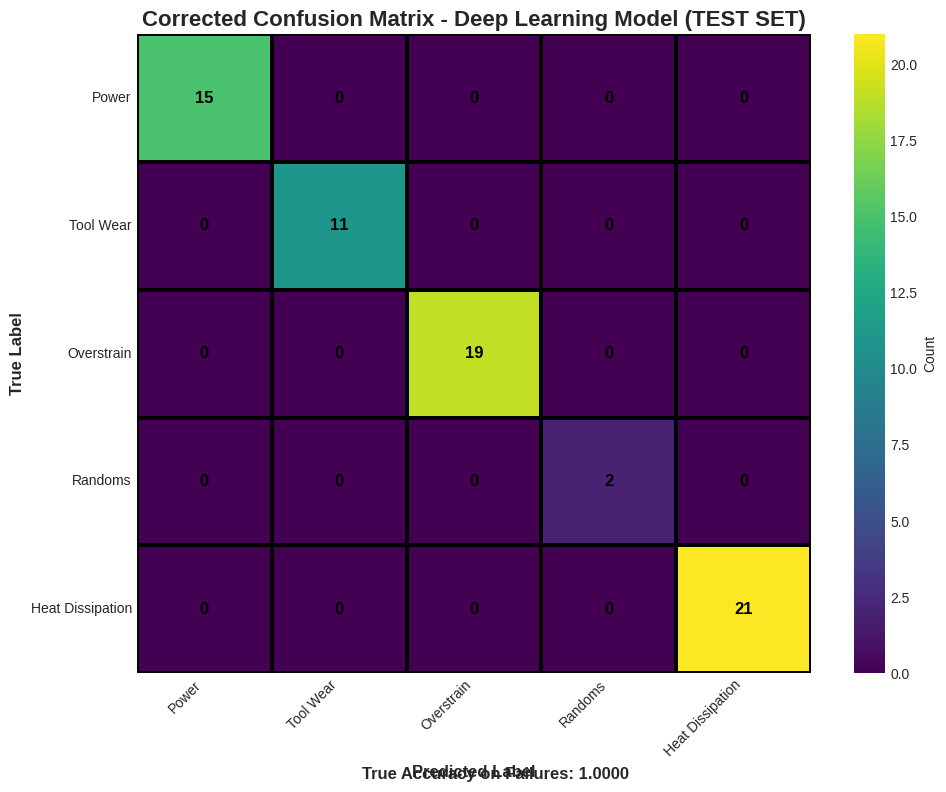


📋 Generating FINAL classification report for failure types on the TEST SET...
                  precision    recall  f1-score  support
Power                   1.0  0.833333  0.909091     18.0
Tool Wear               1.0  0.916667  0.956522     12.0
Overstrain              1.0  1.000000  1.000000     19.0
Randoms                 1.0  1.000000  1.000000      2.0
Heat Dissipation        1.0  1.000000  1.000000     21.0
micro avg               1.0  0.944444  0.971429     72.0
macro avg               1.0  0.950000  0.973123     72.0
weighted avg            1.0  0.944444  0.970026     72.0

📈 Generating Training vs. Validation Loss plot...


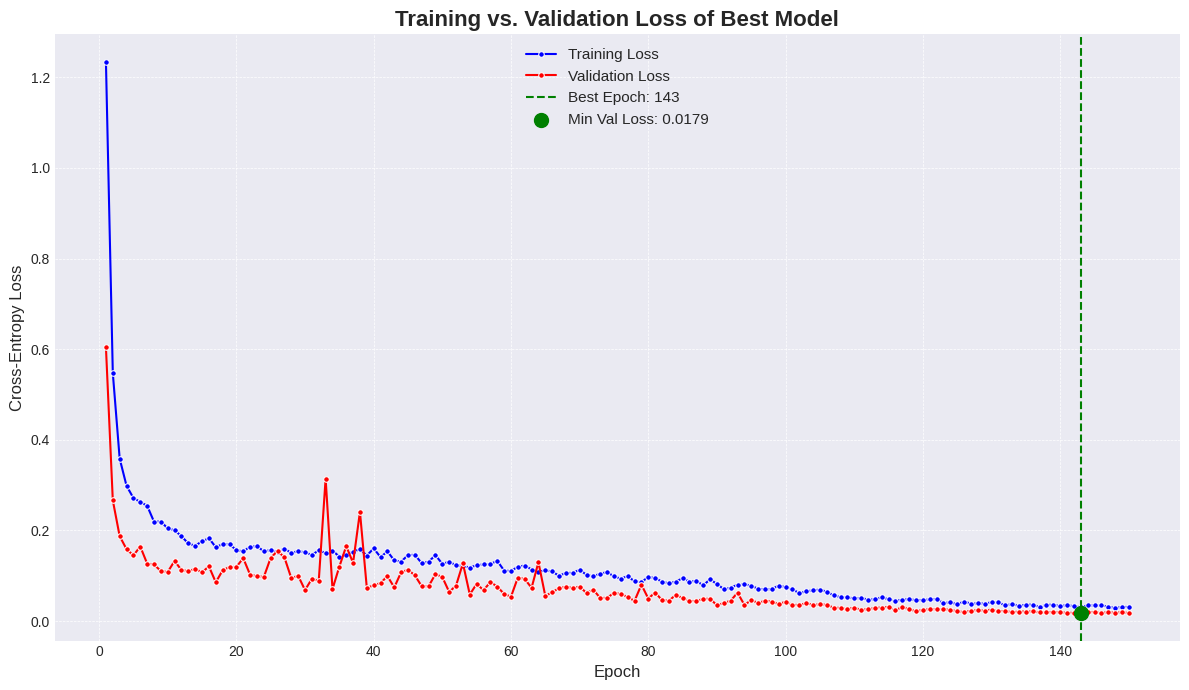


✅ Final Analysis Complete!
Generated files:
 - /Users/anand/Desktop/FAI/ML_Pipeline/confusion_matrix_deep_learning_FINAL_CORRECTED.png
 - /Users/anand/Desktop/FAI/ML_Pipeline/classification_report_deep_learning_FINAL_CORRECTED.csv
 - /Users/anand/Desktop/FAI/ML_Pipeline/training_validation_loss_curves.png


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
import joblib
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os  # Import the 'os' library to handle file paths
import warnings
warnings.filterwarnings('ignore')

# --------------------------------------------------------------------------
# 1. Configuration & Setup
# --------------------------------------------------------------------------
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# --- THE ACTUAL MAPPING THE MODEL WAS TRAINED ON (REVERSE-ENGINEERED) ---
ACTUAL_TRAINING_MAPPING = {
    'No Failure': 0,
    'Power Failure': 1,
    'Tool Wear Failure': 2,
    'Overstrain Failure': 3,
    'Random Failures': 4,
    'Heat Dissipation Failure': 5
}
FAILURE_ONLY_MAP_REVERSED = {
    1: 'Power', 2: 'Tool Wear', 3: 'Overstrain', 4: 'Randoms', 5: 'Heat Dissipation'
}

# --- DEFINE FILE PATHS ---
# Input paths
DATA_PATH = '/content/preprocessed_df.csv'
MODEL_PATH = '/content/best_deep_learning_model.pkl'
SCALER_PATH = '/content/scaler.pkl'
HISTORY_PATH = '/content/best_model_history.pkl'

# --- MODIFICATION 1: Define the specific output path ---
OUTPUT_PATH = '/Users/anand/Desktop/FAI/ML_Pipeline'

# --- MODIFICATION 2: Create the output directory if it doesn't exist ---
os.makedirs(OUTPUT_PATH, exist_ok=True)
print(f"✅ Output files will be saved to: {OUTPUT_PATH}")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"🔥 Using device: {device}")

# --------------------------------------------------------------------------
# 2. PyTorch Model & Dataset Class Definitions
# --------------------------------------------------------------------------
class AdvancedDNN(nn.Module):
    def __init__(self, input_dim: int, num_classes: int, dropout_rate: float = 0.3):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, 512); self.bn1 = nn.BatchNorm1d(512)
        self.block1 = self._make_block(512, 256, dropout_rate); self.block2 = self._make_block(256, 128, dropout_rate)
        self.block3 = self._make_block(128, 64, dropout_rate)
        self.classifier = nn.Sequential(nn.Linear(64, 32), nn.ReLU(), nn.Dropout(dropout_rate), nn.Linear(32, num_classes))
    def _make_block(self, i, o, d): return nn.Sequential(nn.Linear(i, o), nn.BatchNorm1d(o), nn.ReLU(), nn.Dropout(d))
    def forward(self, x):
        x = torch.relu(self.bn1(self.input_layer(x))); x = self.block1(x); x = self.block2(x); x = self.block3(x)
        return self.classifier(x)

class TabularLSTM(nn.Module):
    def __init__(self, input_dim: int, num_classes: int, **kwargs): super().__init__()
class TabularTransformer(nn.Module):
    def __init__(self, input_dim: int, num_classes: int, **kwargs): super().__init__()
class TabularDataset(Dataset):
    def __init__(self, X, y): self.X=X.clone().detach().float(); self.y=y.clone().detach().long()
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

# --------------------------------------------------------------------------
# 3. Data Loading and Preprocessing for Evaluation
# --------------------------------------------------------------------------
print("\n📊 Loading and preparing data using the CORRECT discovered mapping...")
df = pd.read_csv(DATA_PATH)
df_proc = df.drop(['UDI', 'Product ID', 'Target'], axis=1)
y_full = torch.LongTensor(df_proc['Failure Type'].map(ACTUAL_TRAINING_MAPPING).values)
X_features = df_proc.drop('Failure Type', axis=1)
scaler = joblib.load(SCALER_PATH)
num_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
X_numerical_scaled = scaler.transform(X_features[num_features])
X_categorical = pd.get_dummies(X_features['Type'], prefix='Type').values
X_full = torch.FloatTensor(np.concatenate([X_numerical_scaled, X_categorical], axis=1))

# Create and filter the TEST SET
torch.manual_seed(42)
indices = torch.randperm(len(X_full))
train_size = int(0.8 * len(X_full))
test_indices = indices[train_size:]
X_test_full, y_test_full = X_full[test_indices], y_full[test_indices]
failure_mask = y_test_full != 0
X_test, y_test = X_test_full[failure_mask], y_test_full[failure_mask]
print(f"  - Filtered test set for failures only: {len(X_test)} samples.")

# --------------------------------------------------------------------------
# 4. Model Loading and Prediction
# --------------------------------------------------------------------------
print("\n🚀 Loading Deep Learning model for evaluation...")
model = joblib.load(MODEL_PATH)
model = model.to(device)
model.eval()

test_dataset = TabularDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
y_pred_list, y_true_list = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        predictions = torch.argmax(outputs, dim=1).cpu()
        y_pred_list.extend(predictions.numpy()); y_true_list.extend(y_batch.numpy())
y_pred, y_true = np.array(y_pred_list), np.array(y_true_list)

# --------------------------------------------------------------------------
# 5. Analysis Part 1: Confusion Matrix and Classification Report
# --------------------------------------------------------------------------
failure_labels = sorted(list(FAILURE_ONLY_MAP_REVERSED.keys()))
class_names_failures = [FAILURE_ONLY_MAP_REVERSED[l].replace(" Failure", "") for l in failure_labels]

print("\n📈 Generating FINAL confusion matrix for failure types on the TEST SET...")
cm = confusion_matrix(y_true, y_pred, labels=failure_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
            xticklabels=class_names_failures, yticklabels=class_names_failures,
            linewidths=1.5, linecolor='black',
            cbar_kws={'label': 'Count'}, annot_kws={"size":12, "weight":'bold', "color":"black"})
plt.title('Corrected Confusion Matrix - Deep Learning Model (TEST SET)', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold'); plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
accuracy = np.trace(cm) / np.sum(cm)
plt.figtext(0.5, 0.02, f'True Accuracy on Failures: {accuracy:.4f}', ha='center', fontsize=12, fontweight='bold')
plt.tight_layout()

# --- MODIFICATION 3: Save the plot to the specified output path ---
confusion_matrix_save_path = os.path.join(OUTPUT_PATH, 'confusion_matrix_deep_learning_FINAL_CORRECTED.png')
plt.savefig(confusion_matrix_save_path, dpi=300, bbox_inches='tight')
plt.show()

print("\n📋 Generating FINAL classification report for failure types on the TEST SET...")
report = classification_report(y_true, y_pred, labels=failure_labels, target_names=class_names_failures, digits=4, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

# --- MODIFICATION 4: Save the CSV report to the specified output path ---
report_save_path = os.path.join(OUTPUT_PATH, 'classification_report_deep_learning_FINAL_CORRECTED.csv')
report_df.to_csv(report_save_path)

# --------------------------------------------------------------------------
# 6. Analysis Part 2: Training vs. Validation Loss Plot
# --------------------------------------------------------------------------
print("\n📈 Generating Training vs. Validation Loss plot...")
try:
    history = joblib.load(HISTORY_PATH)
    train_loss = history['train_losses']
    val_loss = history['val_losses']
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 7))
    sns.lineplot(x=epochs, y=train_loss, label='Training Loss', color='blue', marker='o', markersize=4)
    sns.lineplot(x=epochs, y=val_loss, label='Validation Loss', color='red', marker='o', markersize=4)
    min_val_loss_epoch = np.argmin(val_loss) + 1
    min_val_loss_value = np.min(val_loss)
    plt.axvline(x=min_val_loss_epoch, color='green', linestyle='--', label=f'Best Epoch: {min_val_loss_epoch}')
    plt.scatter(min_val_loss_epoch, min_val_loss_value, s=100, color='green', zorder=5, label=f'Min Val Loss: {min_val_loss_value:.4f}')
    plt.title('Training vs. Validation Loss of Best Model', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12); plt.ylabel('Cross-Entropy Loss', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()

    # --- MODIFICATION 5: Save the loss plot to the specified output path ---
    loss_curve_save_path = os.path.join(OUTPUT_PATH, 'training_validation_loss_curves.png')
    plt.savefig(loss_curve_save_path, dpi=300)
    plt.show()

except FileNotFoundError:
    print(f"\n⚠️ WARNING: The history file '{HISTORY_PATH}' was not found.")
    print("      Could not generate the loss plot.")
    loss_curve_save_path = "Not generated (history file missing)"

print("\n✅ Final Analysis Complete!")
print("Generated files:")
print(f" - {confusion_matrix_save_path}")
print(f" - {report_save_path}")
print(f" - {loss_curve_save_path}")